IMPORTING LIBRARIES

In [1]:
import numpy as np
import tensorflow as tf
import chess
import chess.pgn
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()

POSITIONAL ENCODING ON TOKENIZED INPUT

In [2]:
def pos_enc_matrix(L, d, n = 10000):
    """Create positional encoding matrix

    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions

    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d))
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

In [3]:
#position embedding class for decoder (to be used as a layer)
#@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(tf.keras.layers.Layer):
    """Positional embedding layer. Assume tokenized input, transform into
    embedding and returns positional-encoded output."""
    def __init__(self, seq_len, vocab_size, embed_dim, **kwargs):
        """
        Args:
            seq_len: Input sequence length
            vocab_size: Input vocab size, for setting up embedding matrix
            embed_dim: Embedding vector size, for setting up embedding matrix
        """
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim     # d_model in paper
        # token embedding layer: Convert integer token to D-dim float vector
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim = vocab_size, output_dim = embed_dim, mask_zero = True
        )
        # positional embedding layer: a matrix of hard-coded sine values
        matrix = pos_enc_matrix(seq_len, embed_dim)
        self.position_embeddings = tf.constant(matrix, dtype = "float32")

    def call(self, inputs):
        """Input tokens convert into embedding vectors then superimposed
        with position vectors"""
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.position_embeddings

    # this layer is using an Embedding layer, which can take a mask
    # passing_mask_tensors_directly_to_layers
    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        # to make save and load a model using custom layer possible
        config = super().get_config()
        config.update({
            "seq_len": self.seq_len,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

ATTENTION FUNCTIONS

In [4]:
def self_attention(input_shape, prefix="att", mask=False, **kwargs):
    """Self-attention layers at transformer encoder and decoder. Assumes its
    input is the output from positional encoding layer.

    Args:
        prefix (str): The prefix added to the layer names
        masked (bool): whether to use causal mask. Should be False on encoder and
                       True on decoder. When True, a mask will be applied such that
                       each location only has access to the locations before it.
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in1")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1")
    add = tf.keras.layers.Add(name=f"{prefix}_add1")
    # functional API to connect input to output
    attout = attention(query=inputs, value=inputs, key=inputs,
                       use_causal_mask=mask)
    outputs = norm(add([inputs, attout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
    return model

In [5]:
def cross_attention(input_shape, context_shape, prefix="att", **kwargs):
    """Cross-attention layers at transformer decoder. Assumes its
    input is the output from positional encoding layer at decoder
    and context is the final output from encoder.

    Args:
        prefix (str): The prefix added to the layer names
    """
    # create layers
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32',
                                    name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in2")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn2", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm2")
    add = tf.keras.layers.Add(name=f"{prefix}_add2")
    # functional API to connect input to output
    attout = attention(query=inputs, value=context, key=context)
    outputs = norm(add([attout, inputs]))
    # create model and return
    model = tf.keras.Model(inputs=[(context, inputs)], outputs=outputs,
                           name=f"{prefix}_cross")
    return model

In [6]:
def feed_forward(input_shape, model_dim, ff_dim, dropout=0.1, prefix="ff"):
    """Feed-forward layers at transformer encoder and decoder. Assumes its
    input is the output from an attention layer with add & norm, the output
    is the output of one encoder or decoder block

    Args:
        model_dim (int): Output dimension of the feed-forward layer, which
                         is also the output dimension of the encoder/decoder
                         block
        ff_dim (int): Internal dimension of the feed-forward layer
        dropout (float): Dropout rate
        prefix (str): The prefix added to the layer names
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in3")
    dense1 = tf.keras.layers.Dense(ff_dim, name=f"{prefix}_ff1", activation="relu")
    dense2 = tf.keras.layers.Dense(model_dim, name=f"{prefix}_ff2")
    drop = tf.keras.layers.Dropout(dropout, name=f"{prefix}_drop")
    add = tf.keras.layers.Add(name=f"{prefix}_add3")
    # functional API to connect input to output
    ffout = drop(dense2(dense1(inputs)))
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3")
    outputs = norm(add([inputs, ffout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_ff")
    return model

In [7]:
def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="enc", **kwargs):
    """One encoder unit. The input and output are in the same shape so we can
    daisy chain multiple encoder units into one larger encoder"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
    return model

In [8]:
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="dec", **kwargs):
    """One decoder unit. The input and output are in the same shape so we can
    daisy chain multiple decoder units into one larger decoder. The context
    vector is also assumed to be the same shape for convenience"""
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                    name=f"{prefix}_ctx0")
    attmodel = self_attention(input_shape, key_dim=key_dim, mask=True,
                              prefix=prefix, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim,
                                 prefix=prefix, **kwargs)
    ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
    x = attmodel(inputs)
    x = crossmodel([(context, x)])
    output = ffmodel(x)
    model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=prefix)
    return model

BUILDING THE TRANSFORMER MODEL

In [9]:
def transformer(num_layers, num_heads, seq_len_enc, seq_len_dec, key_dim, ff_dim, vocab_size_src,
                vocab_size_tgt, dropout=0.1, name="transformer"):
    embed_shape_enc = (seq_len_enc, key_dim)  # output shape of the positional embedding layer (encoder)
    embed_shape_dec = (seq_len_dec, key_dim)
    # set up layers
    input_enc = tf.keras.layers.Input(shape=(seq_len_enc,), dtype="float32",
                                      name="encoder_inputs")
    input_dec = tf.keras.layers.Input(shape=(seq_len_dec,), dtype="int32",
                                      name="decoder_inputs")
    embed_enc = PositionalEmbedding(seq_len_enc, vocab_size_src, key_dim, name="embed_enc")
    embed_dec = PositionalEmbedding(seq_len_dec, vocab_size_tgt, key_dim, name="embed_dec")
    encoders = [encoder(input_shape=embed_shape_enc, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=embed_shape_dec, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    final = tf.keras.layers.Dense(vocab_size_tgt, name="linear")
    # build output
    x1 = embed_enc(input_enc)
    x2 = embed_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])
    output = final(x2)
    # XXX keep this try-except block
    try:
        del output._keras_mask
    except AttributeError:
        pass
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)
    return model

CUSTOM LEARNING RATE SCHEDULING

In [10]:
#@tf.keras.utils.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    "Custom learning rate for Adam optimizer"
    def __init__(self, key_dim, warmup_steps = 4000):
        super().__init__()
        self.key_dim = key_dim
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.key_dim, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype = tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        # to make save and load a model using custom layer possible0
        config = {
            "key_dim": self.key_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config

LOSS FUNCTION AND EVALUATION METRIC

In [11]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis = 2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    mask = label != 0
    match = match & mask
    match = tf.cast(match, dtype = tf.float32)
    mask = tf.cast(mask, dtype = tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

READING THE DATA

In [12]:
with open('start_fens.txt', 'r') as s:
    start_fens = [line.strip() for line in s.readlines()]
with open('themes.txt', 'r') as t:
    themes = [line.strip() for line in t.readlines()]
with open('moves.pkl', 'rb') as m:
    moves = pickle.load(m)
with open('moves_san_nosym.pkl', 'rb') as ms:
    moves_san = pickle.load(ms)

In [13]:
# moves_san = []
# for i in range(len(start_fens)):
#     board = chess.Board(start_fens[i])
#     moves_san_i = []
#     for move in moves[i]:
#         moves_san_i.append(board.san(move))
#         board.push(move)
#     moves_san.append(moves_san_i)

In [14]:
# with open('moves_san.pkl', 'wb') as ms:
#     pickle.dump(moves_san, ms)

In [15]:
indices = [i for i in range(len(start_fens)) if len(themes[i].split(' ')) <= 8 and len(moves[i]) < 9] #filtering the data based on analysis

TOKENIZING THE DECODER I/O (ONLY ON TRAINING DATA)

In [16]:
#Note: vocab_size and seq_length are to be determined after careful examination of the dataset (done above)!
vocab_size_enc = 5000
vocab_size_dec = 37 #tbd from data (themes)
seq_len_dec = 8 #tbd from data
#seq_len_enc = 9 #tbd from data
seq_len_enc = 8
vectorizer_enc = tf.keras.layers.TextVectorization(
    max_tokens = vocab_size_enc,
    standardize = None,
    split = "whitespace",
    output_mode = "int",
    output_sequence_length = seq_len_enc
)
vectorizer_dec = tf.keras.layers.TextVectorization(
    max_tokens = vocab_size_dec,
    standardize = None,
    split = "whitespace",
    output_mode = "int",
    output_sequence_length = seq_len_dec + 1
)

TRAIN-TEST SPLIT

In [17]:
ind_train, ind_test_val = train_test_split(indices, test_size = 0.3, shuffle = True, random_state = 42)
ind_val, ind_test = train_test_split(ind_test_val, test_size = 0.5, random_state = 0)

In [18]:
themes_train = [themes[i] for i in ind_train]
moves_san_train = [' '.join(moves_san[i]) for i in ind_train]
themes_val = [themes[i] for i in ind_val]
moves_san_val = [' '.join(moves_san[i]) for i in ind_val]
vectorizer_dec.adapt(themes_train) #fitting the vectorizer on the training themes data
vectorizer_enc.adapt(moves_san_train)

In [22]:
with open('vectorizer.pkl', 'wb') as fp:
    data = {
        "enc_config":  vectorizer_enc.get_config(),
        "enc_weights": vectorizer_enc.get_weights(),
        "dec_config":  vectorizer_dec.get_config(),
        "dec_weights": vectorizer_dec.get_weights(),
    }
    pickle.dump(data, fp)

In [23]:
vectorizer_enc_loaded = tf.keras.layers.TextVectorization.from_config(data['enc_config'])
vectorizer_enc_loaded.set_weights(data['enc_weights'])
vectorizer_dec_loaded = tf.keras.layers.TextVectorization.from_config(data['dec_config'])
vectorizer_dec_loaded.set_weights(data['dec_weights'])

PREPARING THE DATASET

In [36]:
# set up Dataset object
def format_dataset(moves_san, themes):
    vect_enc = vectorizer_enc(moves_san)
    vect_dec = vectorizer_dec(themes)
    source = {"encoder_inputs": vect_enc,
              "decoder_inputs": vect_dec[:, :-1]}
    target = vect_dec[:, 1:]
    return (source, target)

def make_dataset(moves_san, themes, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((moves_san, themes))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(moves_san_train, themes_train)
val_ds = make_dataset(moves_san_val, themes_val)

TRAINING THE MODEL

In [40]:
#comb tried = [4,8,192,512,0.1]
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
model = transformer(num_layers, num_heads, seq_len_enc, seq_len_dec, key_dim, ff_dim, vocab_size_enc, vocab_size_dec, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)
model.compile(loss = masked_loss, optimizer = optimizer, metrics = [masked_accuracy])

In [42]:
epochs = 1
model.fit(train_ds, epochs = epochs, validation_data = val_ds)

13158/13158 [==============================] - 7666s 574ms/step - loss: 1.0897 - masked_accuracy: 0.6753 - val_loss: 0.8337 - val_masked_accuracy: 0.7354


In [52]:
model.save('trans_model_tokenized_1.keras')

LOADING THE MODEL

In [28]:
custom_objects = {"PositionalEmbedding": PositionalEmbedding,
                  "CustomSchedule": CustomSchedule,
                  "masked_loss": masked_loss,
                  "masked_accuracy": masked_accuracy}
with tf.keras.utils.custom_object_scope(custom_objects):
    model_loaded = tf.keras.models.load_model("trans_model_tokenized_1.keras")

MODEL EVALUATION

In [24]:
def translate(moves_san, seq_len_dec, model, vectorizer_enc, vectorizer_dec):
    """Create the translated sentence"""
    enc_tokens = vectorizer_enc([moves_san])
    lookup = list(vectorizer_dec.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len_dec):
        vector = vectorizer_dec([" ".join(output_sentence)])
        #assert vector.shape == (1, seq_len_dec + 1)
        dec_tokens = vector[:, :-1]
        #assert dec_tokens.shape == (1, seq_len_dec)
        pred = model([enc_tokens, dec_tokens])
        #assert pred.shape == (1, seq_len_dec, vocab_size_dec)
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence

In [25]:
moves_san_test = [' '.join(moves_san[i]) for i in ind_test]

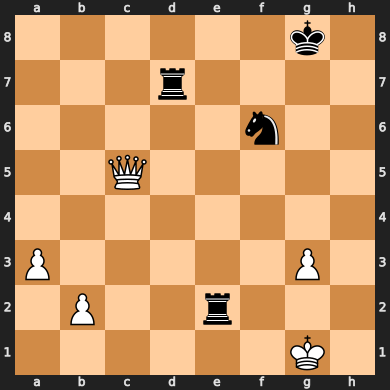

In [26]:
b = chess.Board(start_fens[ind_test[567]])
display(b)

In [31]:
print(themes[ind_test[567]])
translate(moves_san_test[567], seq_len_dec, model_loaded, vectorizer_enc_loaded, vectorizer_dec_loaded)
#translate('Bxf7 Kxf7 Ne6 dxe6 Qxd8 Nc6 Qd2', seq_len_dec, model_loaded, vectorizer_enc_loaded, vectorizer_dec_loaded)

[start] fork [end]


['[start]', 'fork', '[end]']

Model Evaluation

In [ ]:
precision = []
recall = []
f1 = []
for i in range(len(ind_test)):
    pred = translate(moves_san_test[i], seq_len_dec, model_loaded, vectorizer_enc_loaded, vectorizer_dec_loaded)[1:-1]
    true = themes[ind_test[i]].split(' ')[1:-1]
    tp = len(set(pred).intersection(true))
    precision.append(tp/len(pred))
    recall.append(tp/len(true))
    f1.append(2*tp/(len(pred) + len(true)))
print('Precision =', sum(precision)*100/len(precision), '%')
print('Recall =', sum(recall)*100/len(recall), '%')
print('F1 Score =', sum(f1)*100/len(f1), '%')

In [ ]:
# Notes for improvement!!
# include move numbers along with the moves
# Take only fen as input; allow stockfish to generate the rest of the moves.
# Add more tags, consider all possible variations after a move using stockfish, take union of explanation of all variations to understand 
# the move in question